In [8]:
import cv2

import os
import numpy as np
from utils import get_bounding_box_dims
from utils import IOU
import numpy as np
from matplotlib import pyplot as plt


In [25]:
image_list = os.listdir(inp_path)
org_image = cv2.imread(os.path.join(inp_path,image_list[0]))
gt_file = open(gt_path,'r')
gt_file_content = gt_file.readlines()
gt_box_dims = get_bounding_box_dims(gt_file_content, 1)
template = org_image[gt_box_dims[1]:gt_box_dims[3],gt_box_dims[0]:gt_box_dims[2]]
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

In [26]:
p = np.zeros([1,6], dtype = np.float64)

In [27]:
W = np.array([[1+p[0,0],p[0,2],p[0,4]],
                    [p[0,1], 1+p[0,3],p[0,5]]])

In [28]:
frame = cv2.imread(os.path.join(inp_path,image_list[1]))
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame = cv2.warpAffine(frame, W, (frame.shape[1], frame.shape[0]))
input_frame = frame[gt_box_dims[1]:gt_box_dims[3],gt_box_dims[0]:gt_box_dims[2]]

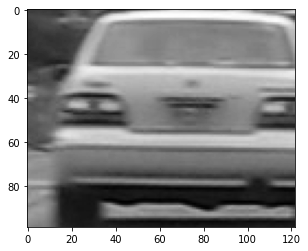

In [41]:
plt.imshow(input_frame,cmap='gray')


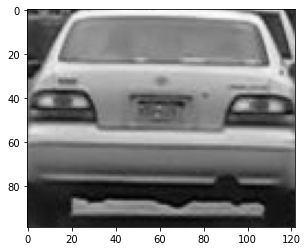

In [43]:
plt.imshow(template,cmap='gray')

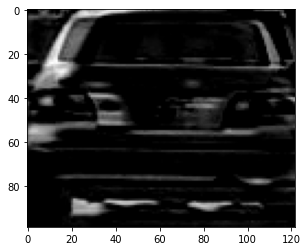

In [45]:
diff = cv2.subtract(template,input_frame)
plt.imshow(diff,cmap='gray')

In [51]:
gradX = cv2.Sobel(input_frame, cv2.CV_64F, 1, 0, ksize=5)
gradY = cv2.Sobel(input_frame, cv2.CV_64F, 0, 1, ksize=5)

ht, wt = template.shape
print(ht,wt)
Xc = np.tile(np.linspace(0, wt-1, wt), (ht, 1)).flatten()
Yc = np.tile(np.linspace(0, ht-1, ht), (wt, 1)).T.flatten()

99 122


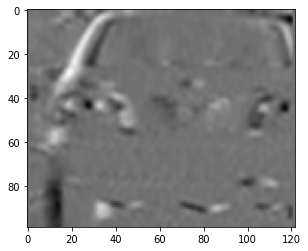

In [52]:
plt.imshow(gradX,cmap='gray')


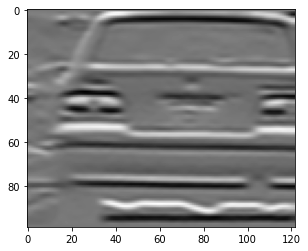

In [53]:
plt.imshow(gradY,cmap='gray')


In [54]:
steepest_descent = np.vstack([gradX.ravel() * Xc, gradY.ravel() * Xc,gradX.ravel()*Yc, gradY.ravel()*Yc, gradX.ravel(), gradY.ravel()]).T

In [56]:
hessian = np.matmul(steepest_descent.T, steepest_descent)
det_hessian = np.linalg.det(hessian)
if det_hessian == 0:
    pass
print(hessian.shape)

(6, 6)


In [57]:
delp = np.matmul(np.linalg.inv(hessian), np.matmul(steepest_descent.T, diff.flatten()))

In [58]:
W= W + np.array([[delp[0],delp[2],delp[4]], [delp[1],delp[3],delp[5]]]) 

In [59]:
def afflineInv(prevWarp):
    R = prevWarp[:,0:2]
    rinv = np.linalg.inv(R)
    trans = np.matmul(rinv,prevWarp[:,2])
    pinv = np.array( [ [rinv[0,0], rinv[0,1] , -trans[0]],  [rinv[1,0], rinv[1,1] , -trans[1]]  ])
    return pinv

In [ ]:
def LK_tracker():
        frame = cv2.imread(os.path.join(inp_path,image_list[i]))
        # frame = cv2.bilateralFilter(source,15,75,75)
        rows, cols, ch = frame.shape
        # source = cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)
        box_pred = [0,0,0,0]
        
        """Initialization for affine"""
        p = np.zeros([1,6], dtype = np.float64)
        W = np.array([[1+p[0,0],p[0,2],p[0,4]],
                    [p[0,1], 1+p[0,3],p[0,5]]])
        thresh=.0001
        error=1
        while(error > thresh):
            """Warping """
            frame = cv2.warpAffine(frame, W, (frame.shape[1], frame.shape[0]))
            input_frame = frame[gt_box_dims[1]:gt_box_dims[3],gt_box_dims[0]:gt_box_dims[2]]
            """Compute Error"""
            diff = template - input_frame
            """Compute Warped Gradients"""
            gradX = cv2.Sobel(input_frame, cv2.CV_64F, 1, 0, ksize=5)
            gradY = cv2.Sobel(input_frame, cv2.CV_64F, 0, 1, ksize=5)
            Height, Weight = template.shape
            Xc = np.tile(np.linspace(0, Weight-1, Weight), (Height, 1)).flatten()
            Yc = np.tile(np.linspace(0, Height-1, Height), (Weight, 1)).T.flatten()
            """Evaluate Jacobian"""
        
            """Compute Steepest Descent"""
            steepest_descent = np.vstack([gradX.ravel() * Xc, gradY.ravel() * Xc,
                                          gradX.ravel()*Yc, gradY.ravel()*Yc, gradX.ravel(), gradY.ravel()]).T
            """Compute Inverse Hessian"""
            hessian = np.matmul(steepest_descent.T, steepest_descent)
            det_hessian = np.linalg.det(hessian)
            if det_hessian == 0:
                error=0
                continue
            """Compute delp by Multplying steepest Descent,Inverse Hessian,"""
            delp = np.matmul(np.linalg.inv(hessian), np.matmul(steepest_descent.T, diff.flatten()))
            """Update p"""
            W= W + np.array([[delp[0],delp[2],delp[4]], [delp[1],delp[3],delp[5]]]) 
            error = np.linalg.norm(delp)
        
        tempPoints  = np.array([np.matmul(afflineInv(W),[x,y,1]) for x,y in gt_box_dims])
        tempPoints = np.round(tempPoints.astype(int))
        plotPoints = [i.astype(int) for i in tempPoints]
        pts = tempPoints.copy()
        pts = pts.reshape((-1,1,2))
        colorImage = cv2.cvtColor(frame,cv2.COLOR_GRAY2RGB)
        cv2.polylines(colorImage,[pts],True,(0,0,255))
        plotPoints = [np.round(i).astype(int) for i in tempPoints] 
        plot2 = cv2.rectangle(frame,(plotPoints[0][0],plotPoints[0][1]),(plotPoints[2][0],plotPoints[2][1]),[0,0,255])